# Gaussian processes with outliers

Suppose there are data distributed according a noisy Gaussian process with outliers at places.
Doing inference with outliers renders the inference useless, and is indeed where point-wise marginal likelihood maximisation falls flat on its face.
With JAXNS we can marginalise over hyper parameters as easily as defining them as prior RVs and marginalising over the posterior.

A Gaussian process is defined by a covariance function, $K : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$, and a mean function $\mu : \mathcal{X} \to \mathbb{R}$.
Given the above data we see that it is equivalent to a Gaussian likelihood, with Gaussian process prior,

$L(x) = p(y | x) = \mathcal{N}[y \mid x, \Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu(X), K(X,X)]$

where $\mu(X)$ and $K(X,X)$ are the mean and covariance functions evaluated over the coordinate locations of the data.

The evidence of this model is well known,

$Z \triangleq p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x = \mathcal{N}[y \mid \mu(X), K(X,X) + \Sigma)$

and likewise the posterior distribution is,

$p(x \mid y) = \mathcal{N}[x \mid \mu', K']$

where

$\mu' = \mu(X) + K(X,X) (K(X,X) + \Sigma)^{-1}(y - \mu(X))$

and

$K' = K(X,X) - K(X,X) (K(X,X) + \Sigma)^{-1} K(X,X)$

## Marginalisation

The mean and covariance functions are not _a priori_ known and thus we must infer them as well.
Let the hyper parameters of the mean and covariance functions, and the noise covariance be $\theta$, and suppose we wish to infer their values.
The likelihood then becomes,

$p(y \mid \theta) = \int_\mathcal{X} L(x | \theta) p(x) p(\theta) \,\mathrm{d} x = \mathcal{N}[y \mid \mu_\theta(X), K_\theta(X,X) + \Sigma_\theta)$

where we recognise this as the marginal likelihood.

Now suppose we wish to predict $x$ at new points $X' \subset \mathcal{X}$, then this equivalent to sampling from the marginalised predictive posterior,

$$p(x(X') | y) = \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) p(y \mid \theta) p(\theta) \mathrm{d} \theta \mathrm{d} x(X)\\
= \mathbb{E}_{\theta \mid y}[p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X)]$$

Now since $p(x(X') \mid x(X))$ and $p(x(X) \mid y, \theta)$ are both Gaussians, their product is also a Gaussian, and is given by,

$$p(x(X') \mid x(X)) p(x(X) \mid y, \theta) = \mathcal{N}[x(X') \mid K(X',X)K(X,X)^{-1} x(X), K(X',X') - K(X',X)K(X,X)^{-1}K(X,X')] \mathcal{N}[x(X) \mid \mu', K']\\
\implies \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X) = \mathcal{N}[x(X') \mid m, S]$$

where

$m = K(X',X)K(X,X)^{-1} \mu'$

and

$S = K(X',X')  + K(X',X) (K(X,X)^{-1} K' K(X,X)^{-1} -  K(X,X)^{-1})K(X,X')$

Therefore, sampling from the marginalised predictive distribution is equivalent to sampling $\theta \sim p(\theta \mid y)$, and then sampling $x(X') \sim \mathcal{N}[x(X') \mid m, S]$.

In [1]:
# for Gaussian processes this is important
from jax import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

from jaxns import marginalise_dynamic
from jax.scipy.linalg import solve_triangular
from jax import random
from jax import numpy as jnp
import pylab as plt
import numpy as np



INFO[2023-12-21 13:26:33,521]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-21 13:26:33,522]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-21 13:26:33,523]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-21 13:26:33,523]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


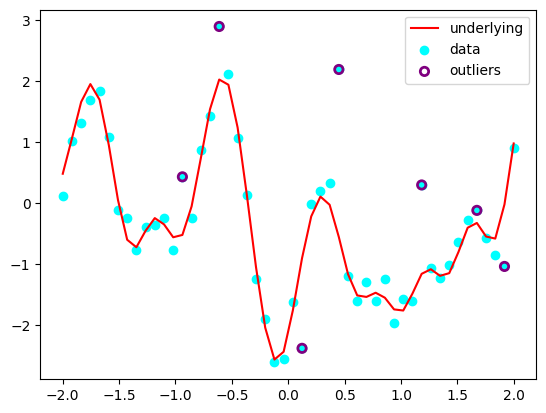

In [2]:
N = 50
num_outliers = int(0.15 * N)
np.random.seed(42)
X = jnp.linspace(-2., 2., N)[:, None]
true_sigma, true_l, true_uncert = 1., 0.2, 0.2
data_mu = jnp.zeros((N,))
prior_cov = tfpk.ExponentiatedQuadratic(amplitude=true_sigma, length_scale=true_l).matrix(X, X) + 1e-13 * jnp.eye(N)

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,)) + data_mu
Y_obs = Y + true_uncert * random.normal(random.PRNGKey(1), shape=(N,))
outliers_mask = jnp.where(jnp.isin(jnp.arange(N), np.random.choice(N, num_outliers, replace=False)), jnp.asarray(True),
                          jnp.asarray(False))
Y_obs = jnp.where(outliers_mask,
                  random.laplace(random.PRNGKey(1), shape=(N,)),
                  Y_obs)
plt.plot(X[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
plt.scatter(X[outliers_mask, 0], Y_obs[outliers_mask], label='outliers', facecolors='none', edgecolors='purple', lw=2)
plt.legend()
plt.show()


In [3]:


import jax
from typing import Type
from jaxns import Prior, Model, NestedSampler


def run_for_kernel(kernel: Type[tfpk.PositiveSemidefiniteKernel]):
    print(("Working on Kernel: {}".format(kernel.__class__.__name__)))

    def log_normal(x, mean, cov):
        L = jnp.linalg.cholesky(cov)
        # U, S, Vh = jnp.linalg.svd(cov)
        log_det = jnp.sum(jnp.log(jnp.diag(L)))  # jnp.sum(jnp.log(S))#
        dx = x - mean
        dx = solve_triangular(L, dx, lower=True)
        # U S Vh V 1/S Uh
        # pinv = (Vh.T.conj() * jnp.where(S!=0., jnp.reciprocal(S), 0.)) @ U.T.conj()
        maha = dx @ dx  # dx @ pinv @ dx#solve_triangular(L, dx, lower=True)
        log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) - log_det - 0.5 * maha
        return log_likelihood

    def log_likelihood(uncert, l, sigma):
        """
        P(Y|sigma, half_width) = N[Y, f, K]
        Args:
            sigma:
            l:

        Returns:

        """
        K = kernel(amplitude=sigma, length_scale=l).matrix(X, X)
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return log_normal(Y_obs, mu, K + data_cov)

    def predict_f(uncert, l, sigma):
        K = kernel(amplitude=sigma, length_scale=l).matrix(X, X)
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return mu + K @ jnp.linalg.solve(K + data_cov, Y_obs)

    def predict_fvar(uncert, l, sigma):
        K = kernel(amplitude=sigma, length_scale=l).matrix(X, X)
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return jnp.diag(K - K @ jnp.linalg.solve(K + data_cov, K))

    # Build the model

    def prior_model():
        l = yield Prior(tfpd.Uniform(0., 2.), name='l')
        uncert = yield Prior(tfpd.HalfNormal(1.), name='uncert')
        sigma = yield Prior(tfpd.Uniform(0., 2.), name='sigma')
        return uncert, l, sigma

    model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

    model.sanity_check(random.PRNGKey(0), S=100)

    # Create the nested sampler class. In this case without any tuning.
    exact_ns = NestedSampler(model=model, max_samples=1e6, parameter_estimation=True)

    termination_reason, state = jax.jit(exact_ns)(random.PRNGKey(42))
    results = exact_ns.to_results(termination_reason=termination_reason, state=state)

    exact_ns.summary(results)
    exact_ns.plot_diagnostics(results)
    exact_ns.plot_cornerplot(results)

    predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                    results.ESS, predict_f)

    predict_fvar = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                       results.ESS, predict_fvar)

    plt.scatter(X[:, 0], Y_obs, label='data')
    plt.plot(X[:, 0], Y, label='underlying')
    plt.plot(X[:, 0], predict_f, label='marginalised')
    plt.plot(X[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
             c='black')
    plt.plot(X[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
             c='black')
    plt.title("Kernel: {}".format(kernel.__class__.__name__))
    plt.legend()
    plt.show()

    return results.log_Z_mean, results.log_Z_uncert

Working on Kernel: _AutoCompositeTensorPsdKernelMeta


INFO[2023-12-21 13:26:35,519]: Sanity check...
INFO[2023-12-21 13:26:35,972]: Sanity check passed


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 71948
samples: 4410
phantom samples: 2970
likelihood evals / sample: 16.3
phantom fraction (%): 67.3%
--------
logZ=-71.33 +- 0.39
H=-5.08
ESS=220
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
l: 0.209 +- 0.043 | 0.159 / 0.208 / 0.265 | 0.185 | 0.185
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.29 +- 0.24 | 1.0 / 1.28 / 1.6 | 1.19 | 1.19
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.599 +- 0.087 | 0.5 / 0.583 / 0.73 | 0.569 | 0.573
--------


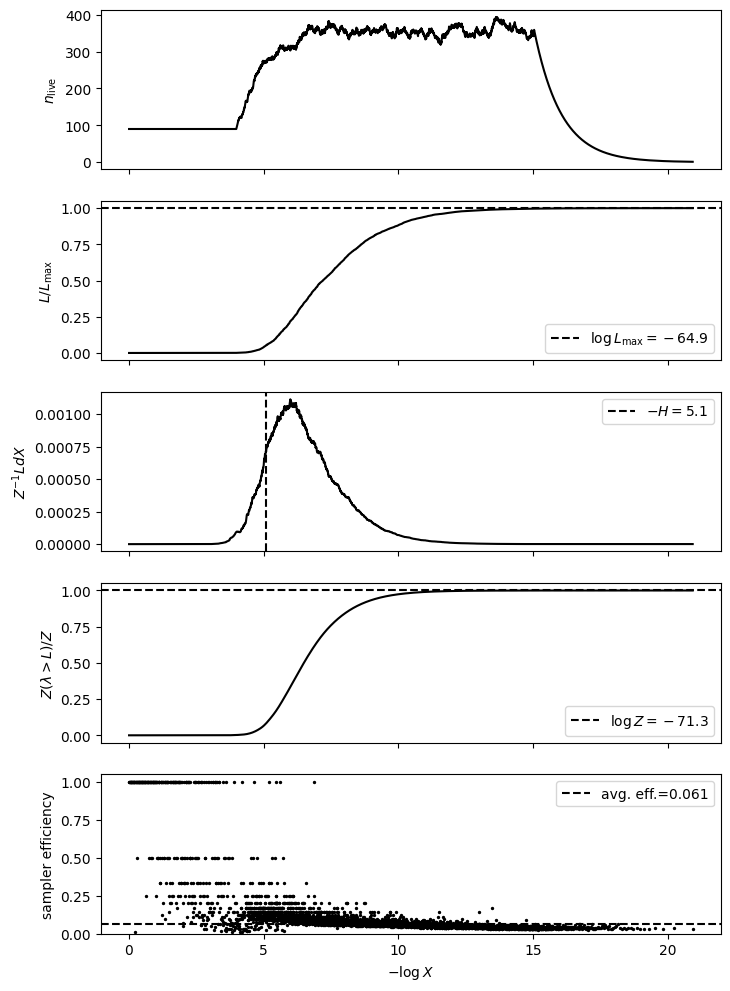

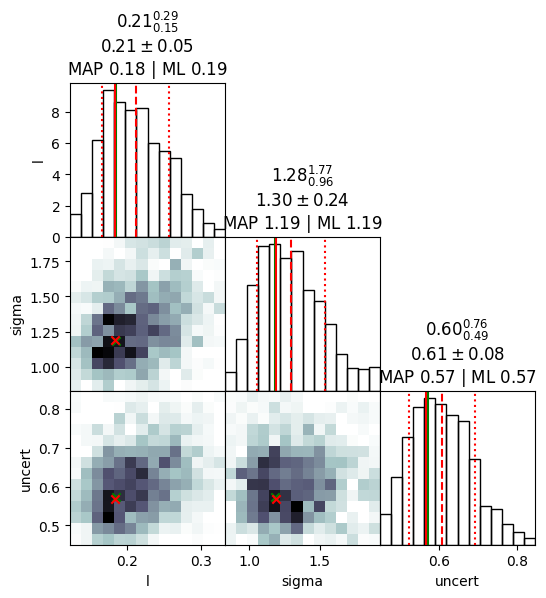

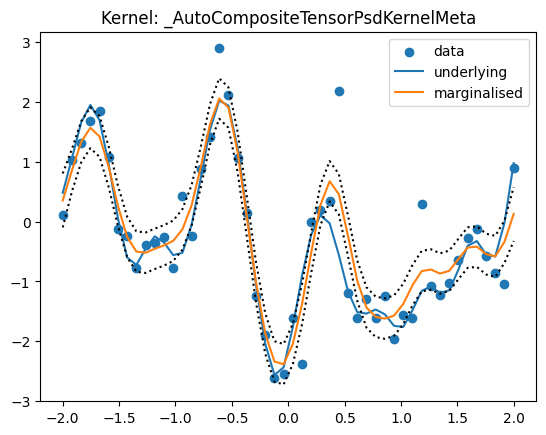

Working on Kernel: _AutoCompositeTensorPsdKernelMeta


INFO[2023-12-21 13:26:57,440]: Sanity check...
INFO[2023-12-21 13:26:57,444]: Sanity check passed


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 52950
samples: 3960
phantom samples: 2700
likelihood evals / sample: 13.4
phantom fraction (%): 68.2%
--------
logZ=-70.82 +- 0.31
H=-2.8
ESS=147
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
l: 0.46 +- 0.26 | 0.21 / 0.42 / 0.79 | 0.24 | 0.24
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.46 +- 0.26 | 1.16 / 1.41 / 1.84 | 1.3 | 1.3
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.3 +- 0.16 | 0.07 / 0.3 / 0.52 | 0.0 | 0.01
--------


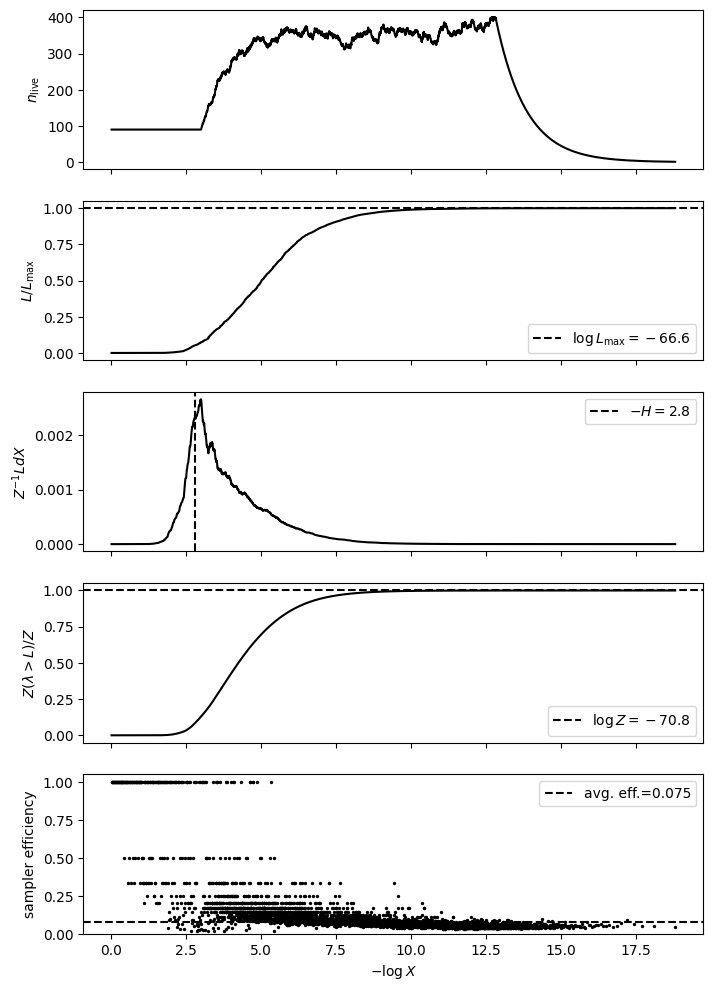

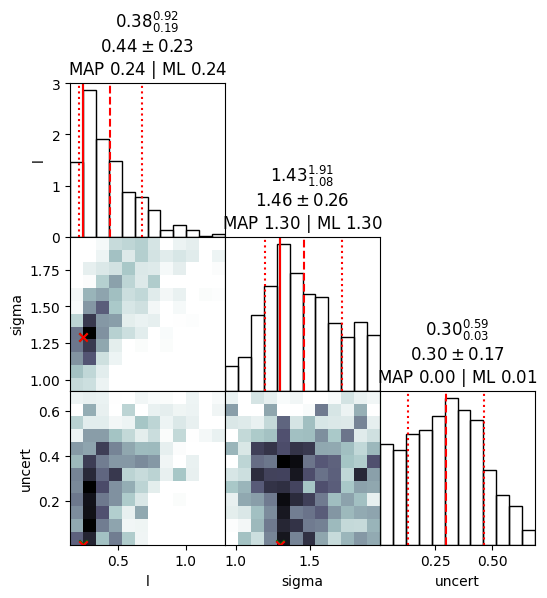

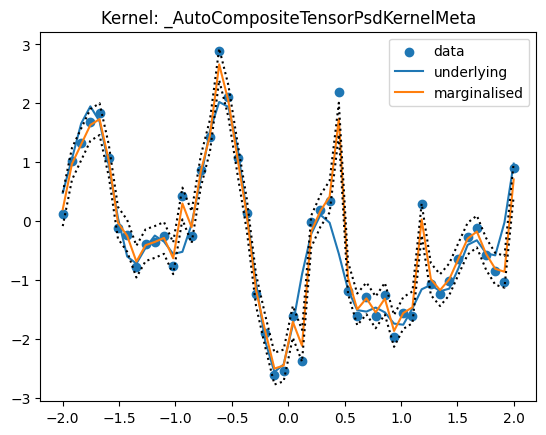

Working on Kernel: _AutoCompositeTensorPsdKernelMeta


INFO[2023-12-21 13:27:14,983]: Sanity check...
INFO[2023-12-21 13:27:14,986]: Sanity check passed


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 64485
samples: 4050
phantom samples: 2700
likelihood evals / sample: 15.9
phantom fraction (%): 66.7%
--------
logZ=-71.14 +- 0.36
H=-3.98
ESS=176
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
l: 0.29 +- 0.088 | 0.19 / 0.279 / 0.413 | 0.236 | 0.238
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.36 +- 0.24 | 1.03 / 1.35 / 1.66 | 1.23 | 1.22
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.55 +- 0.1 | 0.43 / 0.56 / 0.69 | 0.53 | 0.53
--------


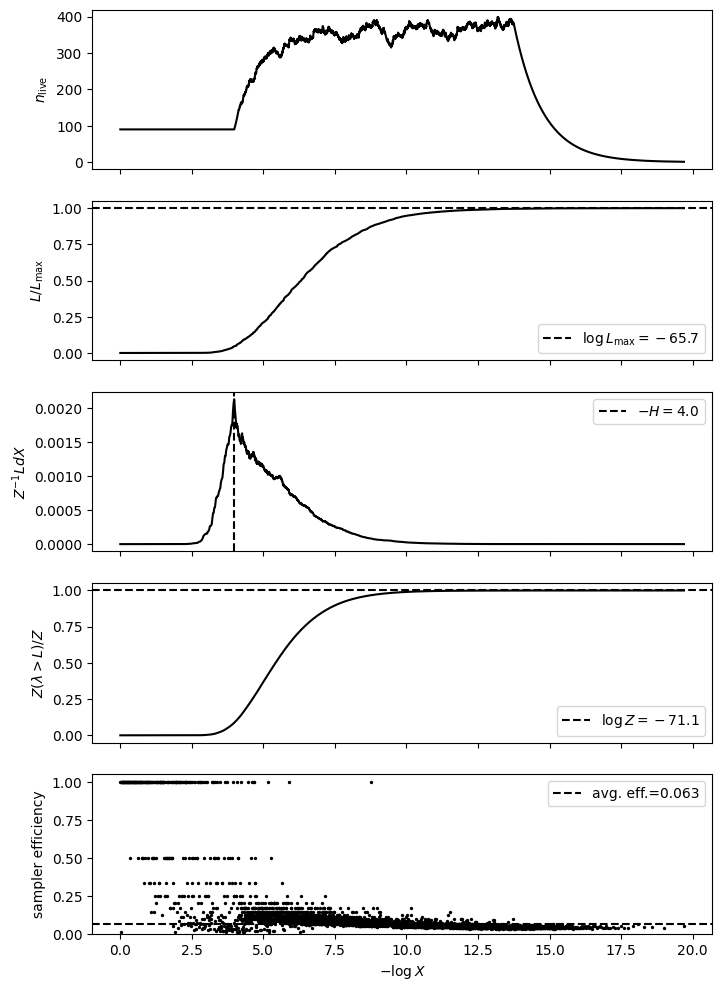

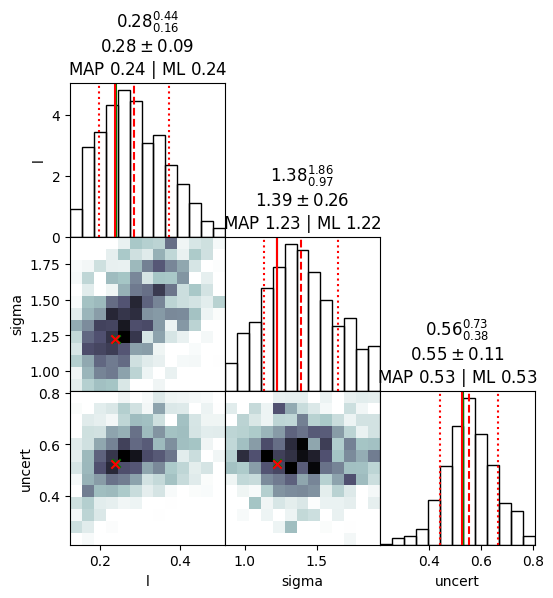

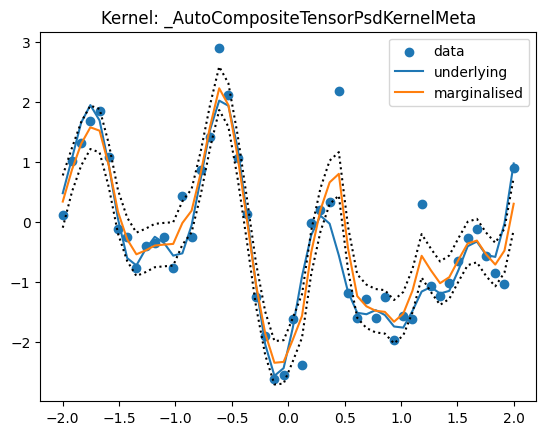

WARNING[2023-12-21 13:27:37,810]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


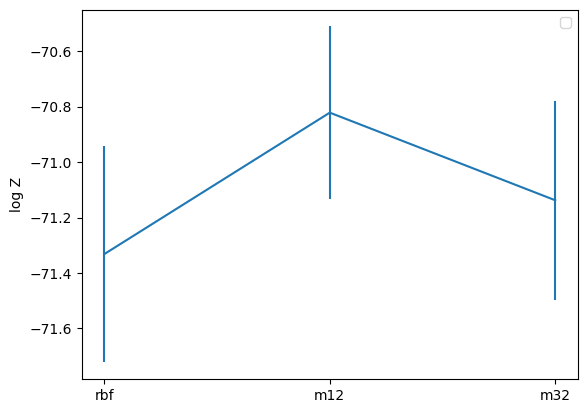

In [4]:
# Let us compare these models.

logZ_rbf, logZerr_rbf = run_for_kernel(tfpk.ExponentiatedQuadratic)
logZ_m12, logZerr_m12 = run_for_kernel(tfpk.MaternOneHalf)
logZ_m32, logZerr_m32 = run_for_kernel(tfpk.MaternThreeHalves)

plt.errorbar(['rbf', 'm12', 'm32'], [logZ_rbf, logZ_m12, logZ_m32], [logZerr_rbf, logZerr_m12, logZerr_m32])
plt.ylabel("log Z")
plt.legend()
plt.show()